# Plots and Charts with Altair

This is my notebook for messing around with Altair. But why learn Altair if you already know `matplotlib` and `seaborn` well? Here are a few reasons:
1. Altair makes supporting interactivity (such as selection, mouseovers, and more) extremely easy - don't worry about learning `plotly`! Just add `.interactive()` at the end of your call.
2. The 'grammar of graphics' for Altair is higher-level than the `seaborn` and `matplotlib` API; once you learn the idioms, creating the plot you want is a fairly straightforward process, requiring little to no fiddling with subplots and other annoyances. 
3. Quit wasting time with `groupby` in pandas. (Or as Raymond Hettinger would say: "don't do that, do this instead!") Altair can do aggregation for you, within-call. Sums, averages, groupbys, and more are all supported.
4. Make visualizations for data you grab from a URL and don't even have. (Altair even provides the ability to rename variables within-call when you don't have access to the raw data.)
5. Intelligent interpretation of your variable types. And you can always hard-specify type in advance by adding :N, :O, :Q, or :T. (nominal, ordinal, quantitative, or temporal)

To get up and running, I highly recommend [Jake VanderPlas' excellent PyCon 2018 tutorial.](https://www.youtube.com/watch?v=ms29ZPUKxbU&t=2548s) The tutorial will give you more of a bird's-eye view of what's possible (and what's unique) in Altair than you could get by poking aimlessly around the documentation.

In [239]:
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np
import numpy.random as r

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [34]:
# Generate blobs with sklearn
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=500, centers=3, n_features=2, random_state=0)

blobs = pd.DataFrame(X, columns=['X1', 'X2'])
blobs['y'] = y

blobs.head()

,X1,X2,y
0,1.103182,4.705777,0
1,-1.932846,3.642251,2
2,-2.034422,1.866002,2
3,1.616402,2.686831,0
4,-0.960010,4.492566,0


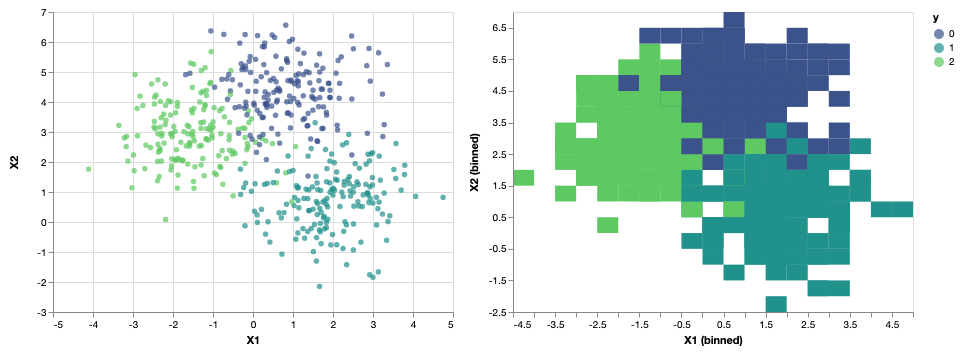

In [243]:
# Scatterplot (I prefer mark_circle to mark_point, though you can also use mark_point and specify a fill)
chart1 = alt.Chart(blobs).mark_circle().encode(
    x='X1',
    y='X2',
    color='y:N').interactive() # Adding interactivity allows us to zoom in and out, pan around

# Rect plot (not super appropriate for this data, but neat for comparison)
chart2 = alt.Chart(blobs).mark_rect().encode(
    alt.X('X1:Q', bin=alt.Bin(maxbins=20)),
    alt.Y('X2:Q', bin=alt.Bin(maxbins=30)),
    color=alt.Color('y:N', scale=alt.Scale(scheme="viridis"))).interactive()

# To plot 2 charts next to each other, simply use |
# Color scale applies to both charts when concatenated
chart1 | chart2 

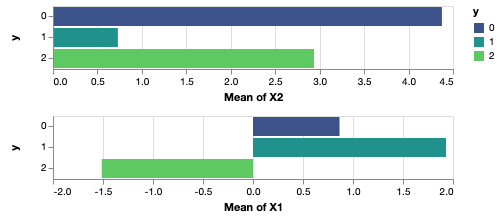

In [242]:
# Make sideways bar charts just by switching x and y! (like in seaborn)
chart1 = alt.Chart(blobs).mark_bar().encode(
            x='mean(X2)', # No pre-calculation of mean necessary - aggregation can be done within the call
            y='y:N',
            color=alt.Color('y:N', scale=alt.Scale(scheme="viridis")))

chart2 = alt.Chart(blobs).mark_bar().encode(
            x='mean(X1)',
            y='y:N',
            color='y:N')

# Vertical concat with &
chart1 & chart2

In [ ]:
# Function taken from my notebook on generating data to practice SQL queries

def generate_data(n=10, seed=10):
    """
    Generates a pandas DataFrame with n (default 10) data points for this particular table. 
    Random number seed is set to 10 by default.
    """
    
    r.seed(seed) # set seed; default 10
    
    order_id = r.randint(1, 100, n) # Order ID
    order_item_id = r.randint(100, 1000, n) # Order item ID
    order_date = generate_dates(n) # # Order date
    product_id = r.randint(1, 51, n) # Product ID
    quantity = r.randint(1, 5, n) # Quantity
    unit_price = r.choice([4.99, 7.99, 12.99, 19.99, 29.99], n) # Unit price
    product_group = r.choice(['cleanser', 'moisturizer', 'toner', 'treatment'], n) # Product group
    
    # Create dict
    d = {'order_id': order_id, 
         'order_item_id': order_item_id,
         'order_date': order_date,
         'product_id': product_id,
         'quantity': quantity,
         'unit_price': unit_price,
         'product_group': product_group}
    
    # Create the DataFrame from the dict
    df = pd.DataFrame(data = d)
    
    return df

orders = generate_data(1000)

/Users/charlenechambliss/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  


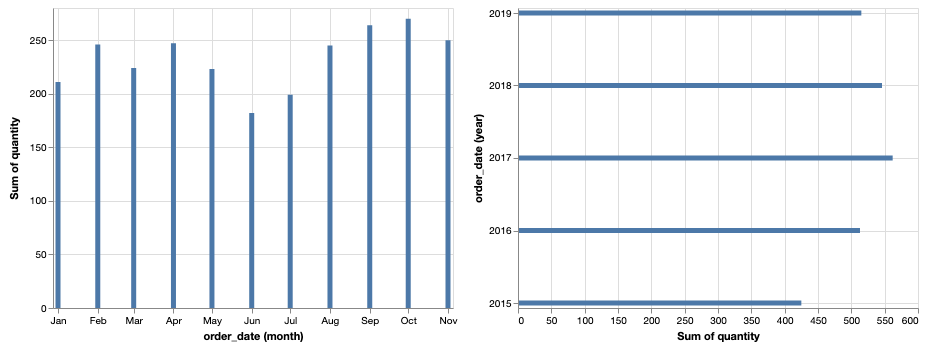

In [96]:
# Time-related charts are made intelligently (or you can specify 'T')
# To aggregate by a time unit, specify `timeUnit`
chart1 = alt.Chart(orders).mark_bar().encode(
        alt.X('order_date:T', timeUnit='month'),
        y='sum(quantity)',
        tooltip='sum(quantity)').interactive() # add a hover tooltip for quantity

chart2 = alt.Chart(orders).mark_bar().encode(
        alt.Y('order_date:T', timeUnit='year'),
        x='sum(quantity)') 

chart1 | chart2

In [97]:
from vega_datasets import data
stocks = data.stocks()
stocks.head()

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


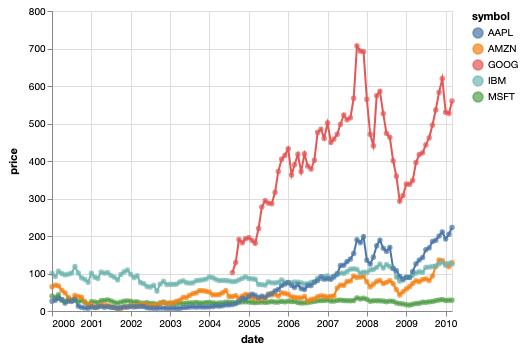

In [100]:
# Compound stock chart
lines = alt.Chart(stocks).mark_line().encode(
    x='date:T',
    y='price:Q',
    color='symbol:N'
)

points = alt.Chart(stocks).mark_circle().encode(
    x='date:T',
    y='price:Q',
    color='symbol:N'
)

# Very intuitive: to add two charts together, simply use '+'
lines + points

Hmm... If I want to plot a Poisson distribution (the PMF), I need the -probabilities- f(x) for each value of x. How do I get those?

In [155]:
gapminder = data.gapminder()
gapminder['log_pop'] = gapminder['pop'].apply(np.log)
gapminder.head()

,cluster,country,fertility,life_expect,pop,year
0,0,Afghanistan,7.7,30.332,8891209,1955
1,0,Afghanistan,7.7,31.997,9829450,1960
2,0,Afghanistan,7.7,34.020,10997885,1965
3,0,Afghanistan,7.7,36.088,12430623,1970
4,0,Afghanistan,7.7,38.438,14132019,1975


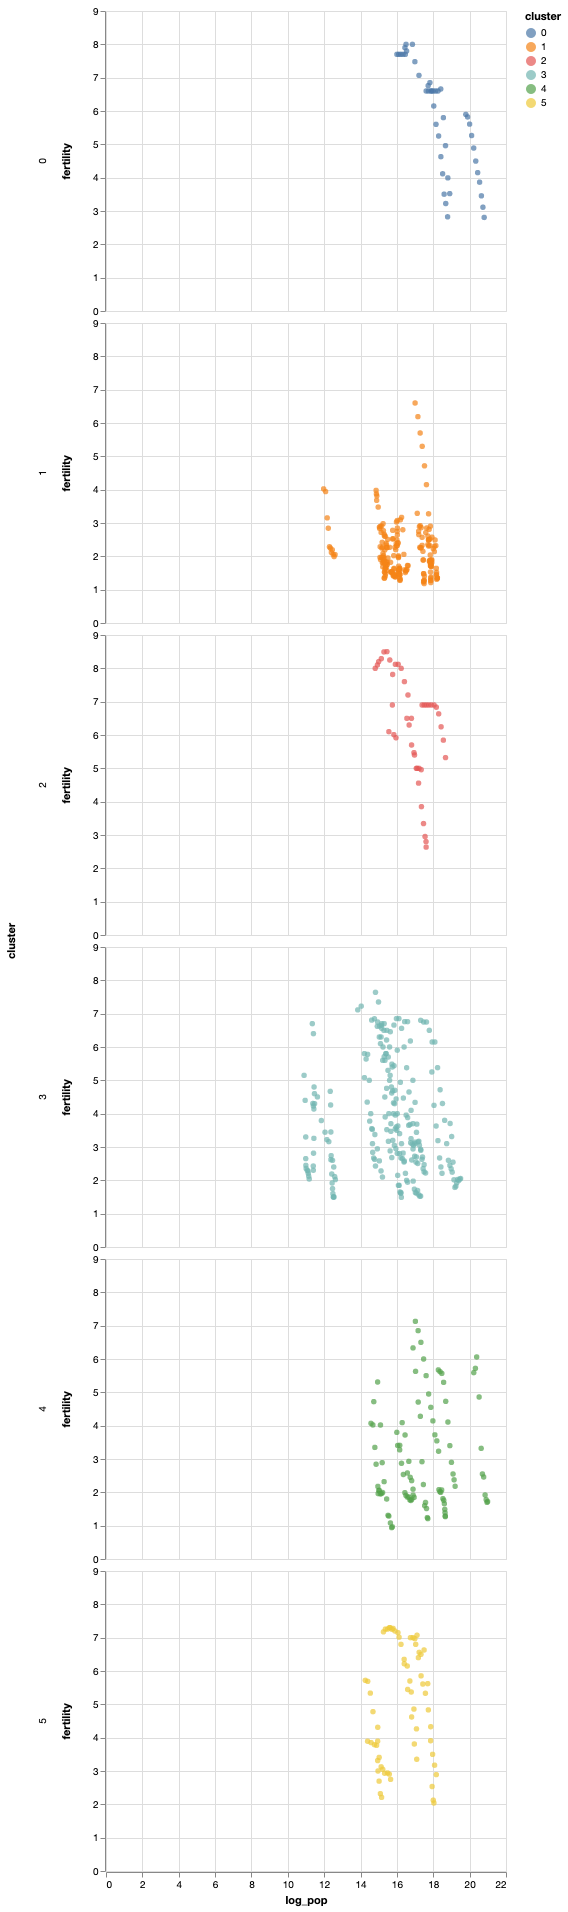

In [214]:
# Add a selection interval: click and drag to create a selection rectangle
# Interval automatically highlights the points in the same area across all charts
interval = alt.selection_interval()

alt.Chart(gapminder).mark_circle().encode(
    x='log_pop',
    y='fertility',
    tooltip='country',
    row='cluster:N',
    color=alt.condition(interval, 'cluster:N', 
                        alt.value('lightgray'))).properties(selection=interval)

In [ ]:
# Any object can be configured!

# alt.Chart.configure_point(),
# alt.Chart.configure_bar(),
# alt.Chart.configure_selection(), etc

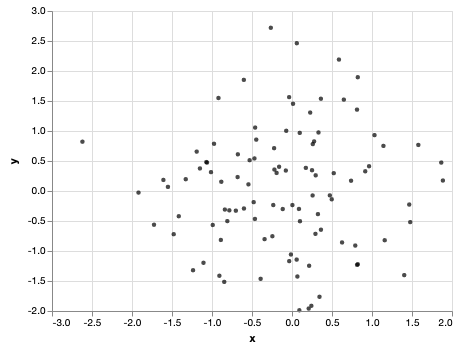

In [195]:
# More random data
np.random.seed(42)
normal = pd.DataFrame(np.random.randn(100, 2), columns=['x', 'y'])

alt.Chart(normal).mark_point().encode(
            x='x:Q',
            y='y:Q'
            ).configure_point( # Change defaults for what the "point" mark looks like
                size=20,
                color='black',
                filled=True)

# But you can't use configure when plotting 2 charts next to each other.
# Also, keep in mind that any specifications within `encode()`, such as color, will supersede `configure()`.

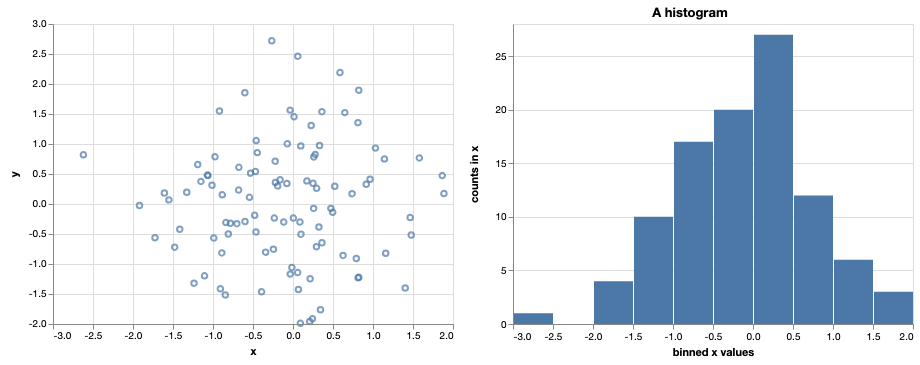

In [199]:
# These two charts aren't special, but figured I would include an example of a standard histogram
scatter = alt.Chart(normal).mark_point().encode(
            x='x:Q',
            y='y:Q'
            )

hist = alt.Chart(normal).mark_bar().encode(
        # Axis title specified within the properties for that variable
        x=alt.X('x', bin=True, title='binned x values'), 
        y=alt.Y('count()', title='counts in x')).properties( # Title is specified within properties
            title='A histogram'
)

scatter | hist

# Color schemes

All of Vega's [named color schemes](https://vega.github.io/vega/docs/schemes/#reference) can be found here, as well as info on how to create your own scheme.

In [203]:
weather = data.seattle_weather()
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


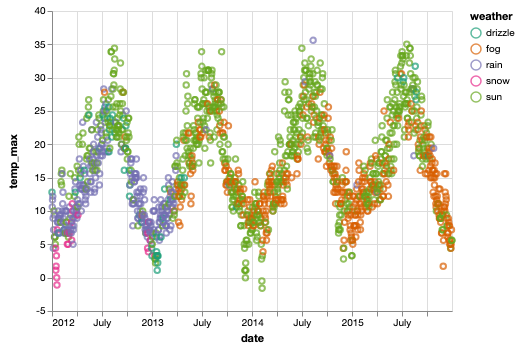

In [217]:
# dark2 theme
alt.Chart(weather).mark_point().encode(
            x='date:T',
            y='temp_max:Q',
            color=alt.Color('weather:N', scale=alt.Scale(scheme="dark2"))
        ).properties()

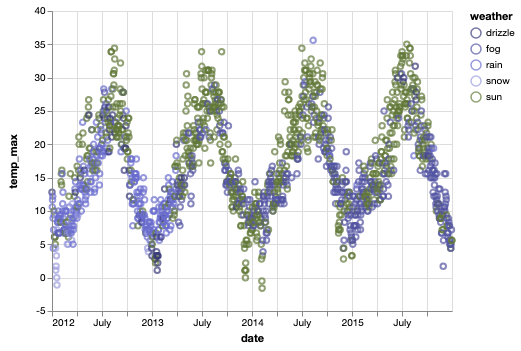

In [215]:
# category20b (there is also category20 and category20a)
alt.Chart(weather).mark_point().encode(
            x='date:T',
            y='temp_max:Q',
            color=alt.Color('weather:N', scale=alt.Scale(scheme="category20b"))
        )

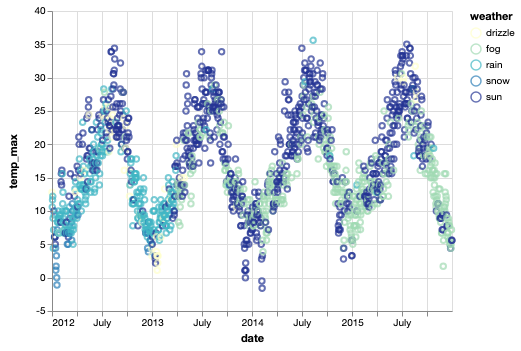

In [210]:
# yellowgreenblue
alt.Chart(weather).mark_point().encode(
            x='date:T',
            y='temp_max:Q',
            color=alt.Color('weather:N', scale=alt.Scale(scheme="yellowgreenblue"))
        )

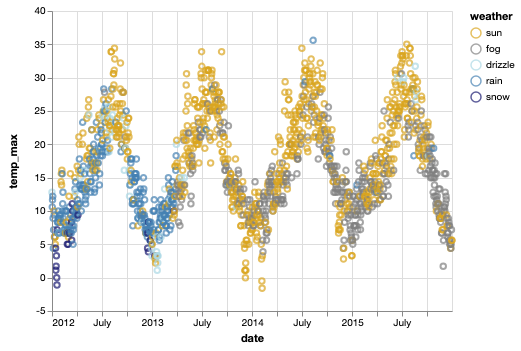

In [235]:
# Very nice custom scale for weather data (from the documentation examples)
# Declare specifics up top, then map into the chart using scale=colorscale
colorscale = alt.Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
                       range=['goldenrod', 'gray', 'lightblue', 'steelblue', 'midnightblue'])

alt.Chart(weather).mark_point().encode(
            x='date:T',
            y='temp_max:Q',
            color=alt.Color('weather:N', scale=colorscale))